## Proyecto final- Speaker recongizer

#### Integrantes

- Diego Flores.
- Rodrigo Lobos.
- Rodrigo Contreras.

### Librerías a utilizar:

#### Librosa:

<img itemprop="image" class="avatar flex-shrink-0 mb-3 mr-3 mb-md-0 mr-md-4" src="https://avatars.githubusercontent.com/u/18124827?s=200&amp;v=4" width="150" height="150" alt="@librosa">

Esta librería nos ayudará a cargar el audio para poder obtener el espectrograma en cuanto a valores de arreglo y a visualizarlo. 

#### Tensorflow:

<img src="https://www.gstatic.com/devrel-devsite/prod/vc5df62aff689c916c31b2ac1e49a7e8c5ecada1bb13dcdd68aaefb1e1e9b9ec0/tensorflow/images/lockup.svg" width="300" height="100" class="devsite-site-logo" alt="TensorFlow">

Con esta libreria podremos hacer el entrenamiento del modelo que usaremos, así como también el uso de keras para llamar al modedlo como tal y definir el modelo de red neuronal.

#### Sklearn:

<img src="//upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/250px-Scikit_learn_logo_small.svg.png" decoding="async" width="230" height="125" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/375px-Scikit_learn_logo_small.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/500px-Scikit_learn_logo_small.svg.png 2x" data-file-width="260" data-file-height="140">

Nos ayudará a normalizar y codificar etiquetas para los datos con los que vamos a entrenar.

#### Importación de bibliotecas en Python:

In [1]:
import numpy as np
import os
from pathlib import Path
import sounddevice as sd
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#### Función de captura de audio:

Esta función nos ayudará a poder capturar la voz en tiempo real, ya con el modelo entrenado es capaz de reconocer al hablante en ese instante.

In [2]:
def record_audio(duration=2, sr=22050):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    print("Recording complete")
    return np.squeeze(audio)

#### Extracción de mfcc del audio:
Tomaremos un sample rate de 22 KHz, común en archivos de audio, el número de coeficientes de 13 para el análisis de coeficientes cepstrales de frecuencias, una ventana de 2048 para la transformada de Fourier, y 512 como número de saltos. Este análisis de audio nos permitirá hacer parte del reconocimiento de voz.

In [3]:
def extract_features(audio, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs.T

#### Preparación o preprocesado de datos de entrenamiento:
Para la automatización del entrenamiento, debemos extraer el MFCC de todos los audios del dataset, hacerles un padding (de ser necesario) para el ajuste de tamaño entre ellas, para retornar una lista de estas MFCCs con las etiquetas asociadas. 

In [4]:
def prepare_data(file_paths, labels, sr=22050, n_mfcc=13, max_pad_len=87):
    features = []
    for file_path in file_paths:
        audio, sr = librosa.load(file_path, sr=sr)
        mfccs = extract_features(audio, sr, n_mfcc)
        if mfccs.shape[0] > max_pad_len:
            mfccs = mfccs[:max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        features.append(mfccs)
    features = np.array(features)
    return features, np.array(labels)

#### Definición de modelo de red neuronal:
En este caso se tienen 3 capas ocultas (por definición), en donde se tiene que:
- La 1° Capa Bidireccional LSTM permite que procese secuencias en ambas direcciones (hacia adelante y hacia atrás), la cual es de 128 unidades.
- La 2° Capa Bidireccional LSTM devuelve la última salida en la secuencia para la siguiente capa densa, esta consta de 64 unidades.
- Capa densa con activación ReLu, totalmente conectada con 32 neuronas y función de activación ReLU (Rectified Linear Unit), que introduce la no linealidad en el modelo.

Como se puede ver,el modelo al compilar se maneja por multiclase y usa el optimizador adam, y una función de pérdida dedicada a la clasificación multiclase, se guía principalmente por el accuracy.

##### Consideraciones:
- Las capas de dropout que se aprecian son para evitar un sobreajuste del entrenamiento
- Se termina utilizando LSTM porque es el más adecuado para el trabajo de secuencia de datos como el audio, CNN se centra más en datos como imágenes o una estructura de cuadrícula.

In [5]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Lectura de dataset y adición de labels:
Se agregan las etiquetas según el nombre de la carpeta donde se encuentran los audios, ya que cada carpeta pertenece a una persona distinta.

In [12]:
file_paths = []
labels = []
voice_filenames = os.listdir("Proyecto/audio-dataset")
for name in voice_filenames:
    dir_path = Path("Proyecto/audio-dataset") / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    file_paths += speaker_sample_paths
    labels += [name] * len(speaker_sample_paths)

#### Normalización y separación de datos para creación y entrenamieno del modelo:

Para este caso, definimos un máximo de 87 de padding (o relleno) de los datos, para luego normalizarlos (StandarScaler) y codificar las labels (LabelEncoder) para el modelo y categorizarlos (por cómo se definió la creación de modelo). FInalmente se toman datos de entrenamiento y testing para la creación y entrenamiento del modelo.

In [62]:
max_pad_len = 87 
features, labels = prepare_data(file_paths, labels, max_pad_len=max_pad_len)

scaler = StandardScaler()
features = scaler.fit_transform(features.reshape(-1, features.shape[-1])).reshape(features.shape)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, random_state=42)

model = create_model((X_train.shape[1], X_train.shape[2]), num_classes=labels_categorical.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))


C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=464
  warnings.warn(


Epoch 1/10


C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.5638 - loss: 0.9547 - val_accuracy: 1.0000 - val_loss: 0.5213
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.3477 - val_accuracy: 1.0000 - val_loss: 0.0991
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9918 - loss: 0.0918 - val_accuracy: 1.0000 - val_loss: 0.0229
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9834 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0220 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 9/10

#### Reconocimiento del hablante:
AL haber entrenado el modelo, ahora tomamos el audio actual del hablante, usamos la función extract_features para obtener los mfcc del audio, lo normalizamos y hacemos el padding del mismo. Luego de eso hacemos la predicción respecto a estos datos y obtenemos el valor máximo de la predicción como del label asociado, para que nos muestre el hablante con el que hizo el mejor match.

In [14]:
def recognize_speaker(audio, sr=22050, threshold=0.9):
    features = extract_features(audio, sr).reshape(1, -1, 13)
    features = scaler.transform(features.reshape(-1, features.shape[-1])).reshape(features.shape)
    features_padded = np.zeros((1, max_pad_len, 13))
    if features.shape[1] > max_pad_len:
        features_padded[0] = features[0, :max_pad_len]
    else:
        features_padded[0, :features.shape[1]] = features[0]
    prediction = model.predict(features_padded)
    max_prob = np.max(prediction)
    if max_prob < threshold:
        return "No se reconoce al hablante"
    label_index = np.argmax(prediction)
    label = label_encoder.inverse_transform([label_index])
    return label[0]

#### Métricas de estudio:
En este caso presentamos la matriz de confusión asociada a los datos, y el reporte de la clasificación hecha.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step

Classification Report
              precision    recall  f1-score   support

       benja       1.00      1.00      1.00         8
       diego       1.00      1.00      1.00         7
       roder       1.00      1.00      1.00         4

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



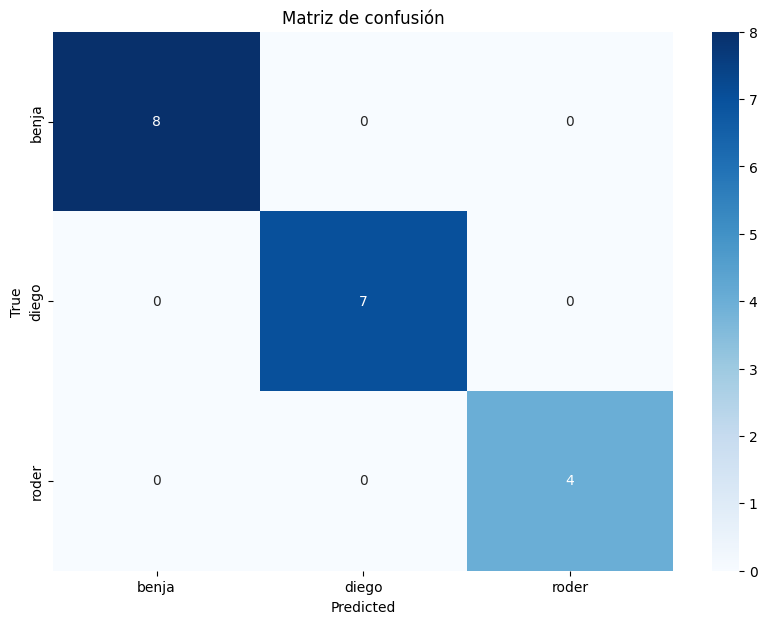

In [15]:
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_indices, y_pred_indices)

report = classification_report(y_test_indices, y_pred_indices, target_names=label_encoder.classes_)
print("\nClassification Report")
print(report)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusión')
plt.show()


#### Llamada a la función para reconocimiento en tiempo real:

In [79]:
audio = record_audio(duration=2)
recognized_speaker = recognize_speaker(audio)
print(f"Hablante reconocido: {recognized_speaker}")

Recording...
Recording complete
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Hablante reconocido: diego
